# ENSO Extratropical Prediction Project

## Problem Description
The scientific goal of this project is to investigate the impact of the extratropics on ENSO predictability and prediction at 1-year lead times. Previous work of mine (add references) as well as many others (add references), have demontrated a link between the extratropics and ENSO development. Many features (predictors) have been identified and they are highly correlated with each other.  Can we identify a better feature or set of features by learning from all of the data rather than a priori choosing features? Can we use this to help us understand the physical and dynamical processes by which the extratropics impact development of ENSO?

### What do we want to predict?

We want to predict Eastern Pacific or Central Pacific ENSO Events in Dec-Jan-Feb (DJF1) from the previous Dec-Jan-Feb (DJF0).  This is defined by indices, referred to as CP for Central Pacific or EP for Eastern Pacific. 

As a regression problem, we would just predict the value of the CP or EP Index in DJF1

As a classification problem, we would define the predictand as:
If the index is >=0.5 for DJF1, then we have a CP or EP El Nino (warm event)
If the index is <=-0.5 for DJF1, then we have a CP or EP La Nina (cold event)

For the purposes of this notebook, will write out the value of the CP or EP index to allow for flexibility in how we want to formulate the problem.

### How will we predict it?

Features (predictors)
:The features for this problem are detrended anomalies of Sea Surface Temperature (SST), sea level pressure (SLP), zonal wind stress (TAUX), zonal wind at 10m (UWND), and meridional wind at 10m (VWND) from observations based datasets at every gridpoint in the Pacific region (65S-85N ;100E-70W). SST and TAUX fields are defined only over the ocean with land points set as np.nan (they output as empty cells in .csv).  SLP, UWND, and VWND are defined over the entire domain (land and ocean).  The correlation with the CP and EP ENSO indices has been removed via linear regression.The features have not been normalized and will likely need to be because the have different scales and variance.

Predictand
: Normalized values of the CP and EP ENSO indices.  These values were calculated originally from SST data , so their original units are deg C, but they have been normalized so are unitless.  Details of how these indices are calculated are described in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014GL059997

### Dataset Reference
1. SST is from NOAA/ERSSTv3b (1x1) 181x89 (deg C)
2. SLP from NCEP Reanalysis 1 (2.5x2.5) 73x144 (hPa)  Note: 1Pa = 1$Nm{-2}$
3. TAUX from NCEP Reanalysis 1 Gaussian Grid 94x192 ($Nm^{-2}$)
4. UWND from NCEP Reanalysis 1 Gaussian Grid 94x192 ($ms^{-1}$)
5. VWND from NCEP Reanalysis 1 Gaussian Grid 94x192 ($ms^{-1}$)

All data are interpolated to the 2.5x2.5 deg grid

## This notebook will:
1. read in the features and predictands from netcdf as monthly data
2. Extract the Pacific from the features datasets
3. Calculate and extract the DJF0 seasonal averages for the features and the DJF1 seasonal averages from the predictand
4. convert the data to a Pandas DataFrame
5.  write out as a .csv file

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import xesmf as xe
import matplotlib.pyplot as plt

Set Path for input and output

In [2]:
path='data/'

Read in the file that has the common grid we will interpolate other fields to

In [3]:
gridFile='NCEPR1.slp.anom.detrend.SEAS.globalreg.1948-2014.nc'
ds_grid=xr.open_dataset(path+gridFile, decode_times=False)
ds_out = xr.Dataset({'lat': ds_grid['lat'],
                     'lon': ds_grid['lon'],})

Define a list of the variables 

In [4]:
varnames=['slp','uflx','uwnd','vwnd','sst']

Setup filenames for the input data

In [5]:
fnames=['NCEPR1.slp.anom.detrend.SEAS.globalreg.1948-2014.nc',
        'NCEPR1.uflx.anom.detrend.SEAS.globalreg.1948-2014.nc',
        'NCEPR1.uwnd.anom.detrend.SEAS.globalreg.1948-2014.nc',
        'NCEPR1.vwnd.anom.detrend.SEAS.globalreg.1948-2014.nc',
        'ERSST.sst.anom.detrend.SEAS.globalreg.1948-2014.nc']

Read in the data files for the predictors (features), interpolate to common grid, create a list of xarray.Datasets

In [6]:
# Create empty list for storing xarray.Datasets
ds_list=[]

# Loop over all the variables and files
for f,v in zip(fnames,varnames):

    # Read in the data
    dsF=xr.open_dataset(path+f, decode_times=False)
    
    # Rename the DataArray to the variable name
    dsF=dsF.rename({'DJF':v})
    
    # Regrid the data to the common grid
    regridder = xe.Regridder(dsF, ds_out, 'bilinear')
    ds_out = regridder(dsF)  
    
    # Set land missing values to NaN for SST
    if (v=='sst'):
        ds_out=ds_out.where(ds_out['sst']<9999,np.nan)
    
    # Append this xarray.Dataset to the list
    ds_list.append(ds_out[v])

    # Clean up regridding weight file
    regridder.clean_weight_file() 

Create weight file: bilinear_73x144_73x144.nc
using dimensions ('lat', 'lon') from data variable slp as the horizontal dimensions for this dataset.
Remove file bilinear_73x144_73x144.nc
Create weight file: bilinear_94x192_73x144.nc
using dimensions ('lat', 'lon') from data variable uflx as the horizontal dimensions for this dataset.
Remove file bilinear_94x192_73x144.nc
Create weight file: bilinear_94x192_73x144.nc
using dimensions ('lat', 'lon') from data variable uwnd as the horizontal dimensions for this dataset.
Remove file bilinear_94x192_73x144.nc
Create weight file: bilinear_94x192_73x144.nc
using dimensions ('lat', 'lon') from data variable vwnd as the horizontal dimensions for this dataset.
Remove file bilinear_94x192_73x144.nc
Create weight file: bilinear_89x181_73x144.nc
using dimensions ('lat', 'lon') from data variable sst as the horizontal dimensions for this dataset.
Remove file bilinear_89x181_73x144.nc


File for the predictands

In [7]:
fnamecp='cp.pc.ERSST.SEAS.nc'
fnameep='ep.pc.ERSST.SEAS.nc'

Read in the predictands and append to the xarray.Dataset list

In [8]:
ds_cp=xr.open_dataset(path+fnamecp, decode_times=False).squeeze()
ds_ep=xr.open_dataset(path+fnameep, decode_times=False).squeeze()

ds_cp=ds_cp.rename({'djf1':'cp'})
ds_ep=ds_ep.rename({'djf1':'ep'})

ds_list.append(ds_cp['cp'])
ds_list.append(ds_ep['ep'])

Combine all the xarray.Dataset variables into a single xarray.Dataset and assign the date/times properly

In [9]:
ds=xr.merge(ds_list)   
ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 67)
Coordinates:
  * time     (time) float64 0.0 12.0 24.0 36.0 48.0 ... 756.0 768.0 780.0 792.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Data variables:
    slp      (time, lat, lon) float64 -4.798 -4.798 -4.798 ... 0.7842 0.7842
    uflx     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    uwnd     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    vwnd     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    sst      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cp       (time) float64 ...
    ep       (time) float64 ...

Extract the Pacific Ocean region from 65S to 85N and 100E to 70W

In [10]:
ds_pac=ds.sel(lat=slice(-65,85),lon=slice(100,290))
ds_pac

<xarray.Dataset>
Dimensions:  (lat: 61, lon: 77, time: 67)
Coordinates:
  * time     (time) float64 0.0 12.0 24.0 36.0 48.0 ... 756.0 768.0 780.0 792.0
  * lon      (lon) float64 100.0 102.5 105.0 107.5 ... 282.5 285.0 287.5 290.0
  * lat      (lat) float64 -65.0 -62.5 -60.0 -57.5 -55.0 ... 77.5 80.0 82.5 85.0
Data variables:
    slp      (time, lat, lon) float64 -0.1153 -0.05944 ... -1.04 -1.077
    uflx     (time, lat, lon) float64 0.04817 0.05325 ... 0.004714 0.004549
    uwnd     (time, lat, lon) float64 -2.204 -2.158 -2.148 ... -0.04894 -0.05836
    vwnd     (time, lat, lon) float64 0.2712 0.2623 0.1809 ... -0.3727 -0.3475
    sst      (time, lat, lon) float64 nan nan nan ... -3.785e-06 -4.544e-05
    cp       (time) float64 ...
    ep       (time) float64 ...

Quick check plot

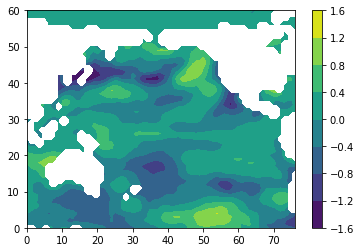

In [11]:
plt.contourf(ds_pac['sst'][0,:,:])
plt.colorbar()

Add in date/time information

In [23]:
times=pd.date_range(start='1949', end='2015', freq="AS")
ds_pac['time']=times
times

DatetimeIndex(['1949-01-01', '1950-01-01', '1951-01-01', '1952-01-01',
               '1953-01-01', '1954-01-01', '1955-01-01', '1956-01-01',
               '1957-01-01', '1958-01-01', '1959-01-01', '1960-01-01',
               '1961-01-01', '1962-01-01', '1963-01-01', '1964-01-01',
               '1965-01-01', '1966-01-01', '1967-01-01', '1968-01-01',
               '1969-01-01', '1970-01-01', '1971-01-01', '1972-01-01',
               '1973-01-01', '1974-01-01', '1975-01-01', '1976-01-01',
               '1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
      

Convert to pandas dataframe

In [20]:
df=ds_pac.to_dataframe().round(5)
df

slp     uflx     uwnd     vwnd      sst       cp  \
lat   lon   time                                                               
-65.0 100.0 1949-01-01 -0.11530  0.04817 -2.20402  0.27120      NaN -0.02281   
            1950-01-01  7.32489  0.02882 -1.57926  0.71625      NaN -0.87673   
            1951-01-01  5.41538 -0.00448 -0.24469  0.17615      NaN -0.98041   
            1952-01-01 -1.95160 -0.03209  1.17377  0.05977      NaN -0.08687   
            1953-01-01  2.86104  0.03164 -1.52378 -0.13286      NaN  0.00190   
...                         ...      ...      ...      ...      ...      ...   
 85.0 290.0 2011-01-01  6.78036  0.02160 -0.67441  0.66685 -0.00004 -2.02178   
            2012-01-01  0.46223  0.01232 -0.55325  0.40512 -0.00004 -1.55203   
            2013-01-01 -4.59476 -0.01653  0.45551  0.20548 -0.00004 -0.26607   
            2014-01-01  4.40266  0.05602 -1.26657 -0.84639 -0.00004 -0.24398   
            2015-01-01 -1.07749  0.00455 -0.05836 -0.34751 -0.00005      NaN   

                             ep  
lat   lon   time                 
-65.0 100.0 1949-01-01  0.16433  
            1950-01-01 -0.91307  
            1951-01-01 -0.15738  
            1952-01-01  1.13814  
            1953-01-01  0.58604  
...                         ...  
 85.0 290.0 2011-01-01 -0.48754  
            2012-01-01  0.06250  
            2013-01-01 -0.75166  
            2014-01-01 -0.74899  
            2015-01-01      NaN  

[314699 rows x 7 columns]

Write to csv

In [22]:
df.to_csv('pacocnDJFcpepDJF1.csv')